# Final Import Zillow Data
## Brian Goggin
In this assignment, I import data from the San Francisco development pipeline from SF Open data's API. I import quarterly data from the fourth quarter of 2012 to the second quarter of 2016. In the first section of the notebook, I import, append, and clean the data. In other notebooks, I use this data to explore development activity in SF. 

## Section 1: Import and Clean Data

First, import the packages necessary for calling an API. 

In [108]:
#import packages
import pandas as pd
import numpy as np
import re as re
import json    # library for working with JSON-formatted text strings
import requests  # library for accessing content from web URLs
import pprint  # library for making Python data structures readable
pp = pprint.PrettyPrinter()
import os
import matplotlib as mil
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf

In [109]:
#set directory
root = "/Users/briangoggin/Dropbox/CP 255/SF Development Project/"

In [110]:
#import data
import_file = root+"Raw Data/Zillow Rent Data/Neighborhood_Zri_AllHomesPlusMultifamily.csv"
rent = pd.read_csv(import_file)

In [111]:
#keep only observations from SF
rent = rent[rent['City'] == 'San Francisco']
#rent.head(20)

In [112]:
#Keep only certain months
columns = ['2010-11', '2010-12', '2011-01', '2011-02','2011-03', '2011-04','2011-05',
           '2011-06','2011-07', '2011-08','2011-09', '2011-10','2011-11','2011-12',
           '2012-01','2012-02', '2012-03','2012-04','2012-05','2012-06','2012-07',
           '2012-08','2012-09','2016-04', '2016-05', '2016-06', '2016-07', '2016-08',
           '2016-09']

rent.drop(columns, axis = 1, inplace = True)
#rent.head()

In [113]:
#Compute change in rent metric
rent['change'] = 100*((rent['2016-03'] - rent['2012-10'])/rent['2012-10'])
#rent.head(10)

In [114]:
#compute average rent
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
years = ['2013' ,'2014', '2015']
columns = []
for y in years:
    for m in months:
        columns.append(y+'-'+m)

moreyears = ['2012-10', '2012-11', '2012-12', '2016-01', '2016-02','2016-03']

for i in moreyears:
    columns.append(i)
    
rent['avg_rent'] = rent[columns].mean(axis=1)

# Figures

In [115]:
units = pd.read_csv(root+"Intermediate Files/completed.csv")
units.drop(['NAME', 'REGIONID', 'geometry'], axis = 1, inplace = True)


In [116]:
# Merge data. Left with only 29 observations after this but oh well. Simple data statistics, it is.
df = rent.merge(units, on = 'RegionID', how = "outer",  indicator=True)
df = df[df['_merge'] == 'both'] #drop all observations not in both files. This drops 5 (darn, but full steam ahead) neighborhoods from the unit file


In [117]:
#Use OLS to estimate price based on square feet.
results = smf.ols('change ~  net_units', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 change   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     2.902
Date:                Mon, 21 Nov 2016   Prob (F-statistic):             0.0999
Time:                        23:19:51   Log-Likelihood:                -101.40
No. Observations:                  29   AIC:                             206.8
Df Residuals:                      27   BIC:                             209.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     55.5678      1.619     34.324      0.0

In [124]:
#Use OLS to estimate correlation between net units and average rent
results = smf.ols('avg_rent ~  net_units', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               avg_rent   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.2862
Date:                Mon, 21 Nov 2016   Prob (F-statistic):              0.597
Time:                        23:33:41   Log-Likelihood:                -256.30
No. Observations:                  29   AIC:                             516.6
Df Residuals:                      27   BIC:                             519.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   4366.4515    338.070     12.916      0.0

In [118]:
#Set export path
export = root+"/Output/"

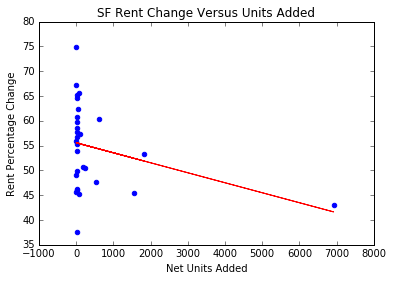

In [123]:
fig, ax = plt.subplots()
plt.title('SF Rent Change Versus Units Added')
plt.xlabel('Net Units Added')
plt.ylabel('Rent Percentage Change')
fit = np.polyfit(df['net_units'], df['change'], deg=1)
ax.plot(df['net_units'], fit[0] * df['net_units'] + fit[1], color='red')
ax.scatter(df['net_units'], df['change'], color='blue', alpha=1, s=20)
plt.savefig(export+"/reg1.png",dpi=200)

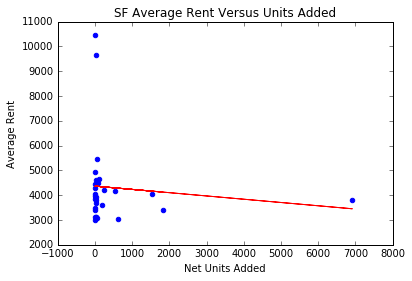

In [120]:
fig, ax = plt.subplots()
plt.title('SF Average Rent Versus Units Added')
plt.xlabel('Net Units Added')
plt.ylabel('Average Rent')
fit = np.polyfit(df['net_units'], df['avg_rent'], deg=1)
ax.plot(df['net_units'], fit[0] * df['net_units'] + fit[1], color='red')
ax.scatter(df['net_units'], df['avg_rent'], color='blue', alpha=1, s=20)
plt.savefig(export+"/reg2.png",dpi=200)

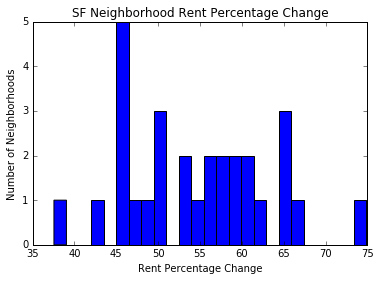

In [121]:
plt.title('SF Neighborhood Rent Percentage Change')
plt.hist(df['change'], bins = 25, color='blue')
plt.xlabel('Rent Percentage Change')
plt.ylabel('Number of Neighborhoods')
plt.savefig(root+"2010_racial_distributuon_bay_area.png",dpi=150)
plt.savefig(export+"/hist1.png",dpi=200)

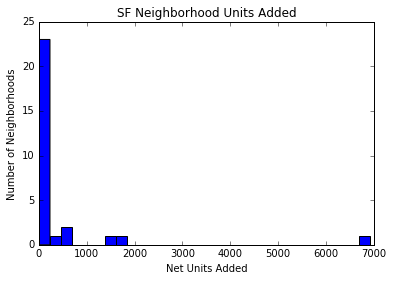

In [122]:
plt.title('SF Neighborhood Units Added')
plt.hist(df['net_units'], bins = 30, color='blue')
plt.xlabel('Net Units Added')
plt.ylabel('Number of Neighborhoods')
plt.savefig(export+"/hist2.png",dpi=200)

In [126]:
df.sort_values('net_units', ascending = False)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2012-10,2012-11,2012-12,...,2015-12,2016-01,2016-02,2016-03,change,avg_rent,net_units,net_affordable_units,name,_merge
11,268491,South of Market,San Francisco,CA,San Francisco,San Francisco,658.0,3032.0,3001.0,3000.0,...,4446.0,4413.0,4371.0,4337.0,43.040897,3822.333333,6920.0,539.0,South Of Market,both
6,268114,Downtown,San Francisco,CA,San Francisco,San Francisco,613.0,2686.0,2669.0,2692.0,...,3965.0,3999.0,4048.0,4116.0,53.239017,3401.404762,1828.0,103.0,Downtown,both
30,118904,Western Addition,San Francisco,CA,San Francisco,San Francisco,1224.0,3173.0,3154.0,3214.0,...,4705.0,4649.0,4627.0,4616.0,45.477466,4033.095238,1544.0,258.0,Western Addition,both
4,272885,Bayview,San Francisco,CA,San Francisco,San Francisco,537.0,2361.0,2353.0,2381.0,...,3865.0,3823.0,3802.0,3784.0,60.271072,3044.833333,624.0,165.0,Bayview,both
0,274552,Mission,San Francisco,CA,San Francisco,San Francisco,130.0,3367.0,3326.0,3298.0,...,5032.0,5025.0,4999.0,4973.0,47.698248,4160.642857,535.0,0.0,Mission,both
27,268414,Potrero Hill,San Francisco,CA,San Francisco,San Francisco,1186.0,3376.0,3317.0,3261.0,...,5134.0,5133.0,5111.0,5079.0,50.444313,4218.500000,238.0,0.0,Potrero Hill,both
43,274246,Lakeshore,San Francisco,CA,San Francisco,San Francisco,2531.0,2980.0,2966.0,2898.0,...,4380.0,4415.0,4450.0,4491.0,50.704698,3607.809524,197.0,0.0,Lakeshore,both
7,268337,Nob Hill,San Francisco,CA,San Francisco,San Francisco,632.0,3645.0,3646.0,3658.0,...,5816.0,5817.0,5781.0,5735.0,57.338820,4658.214286,113.0,0.0,Nob Hill,both
41,116918,North Beach,San Francisco,CA,San Francisco,San Francisco,2127.0,3671.0,3680.0,3689.0,...,5397.0,5408.0,5365.0,5333.0,45.273767,4494.619048,78.0,0.0,North Beach,both
39,274872,Oceanview,San Francisco,CA,San Francisco,San Francisco,1857.0,2392.0,2395.0,2409.0,...,3878.0,3913.0,3947.0,3959.0,65.510033,3085.023810,69.0,4.0,Ocean View,both


In [128]:
rent.sort_values('change', ascending = True)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2012-10,2012-11,2012-12,...,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,change,avg_rent
3701,275789,Twin Peaks,San Francisco,CA,San Francisco,San Francisco,3702,3286,3209,3173,...,4613,4639,4654,4654,4620,4581,4547,4520,37.553256,3971.214286
4696,417492,North Waterfront,San Francisco,CA,San Francisco,San Francisco,4697,3287,3315,3366,...,4488,4522,4561,4596,4609,4593,4572,4555,38.576209,4019.571429
1072,417501,Lower Pacific Heights,San Francisco,CA,San Francisco,San Francisco,1073,3483,3457,3453,...,4971,5011,5041,5027,4971,4916,4878,4857,39.448751,4270.904762
3204,417502,Yerba Buena,San Francisco,CA,San Francisco,San Francisco,3205,3137,3090,3065,...,4459,4498,4521,4535,4524,4508,4484,4445,41.695888,3891.238095
657,268491,South of Market,San Francisco,CA,San Francisco,San Francisco,658,3032,3001,3000,...,4390,4429,4455,4460,4446,4413,4371,4337,43.040897,3822.333333
555,417497,Central Sunset,San Francisco,CA,San Francisco,San Francisco,556,3012,2963,2910,...,4080,4141,4203,4234,4238,4261,4289,4321,43.459495,3613.285714
3645,417498,Midtown Terrace,San Francisco,CA,San Francisco,San Francisco,3646,3150,3091,3037,...,4415,4444,4480,4511,4532,4548,4548,4536,44.000000,3808.452381
2126,116918,North Beach,San Francisco,CA,San Francisco,San Francisco,2127,3671,3680,3689,...,5260,5314,5342,5400,5397,5408,5365,5333,45.273767,4494.619048
1223,118904,Western Addition,San Francisco,CA,San Francisco,San Francisco,1224,3173,3154,3214,...,4646,4688,4744,4740,4705,4649,4627,4616,45.477466,4033.095238
649,268396,Parkside,San Francisco,CA,San Francisco,San Francisco,650,2914,2903,2879,...,3971,4049,4085,4093,4097,4134,4189,4245,45.676047,3493.619048


In [140]:
df[df['RegionID']== 268396]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2012-10,2012-11,2012-12,...,2015-12,2016-01,2016-02,2016-03,change,avg_rent,net_units,net_affordable_units,name,_merge
9,268396,Parkside,San Francisco,CA,San Francisco,San Francisco,650.0,2914.0,2903.0,2879.0,...,4097.0,4134.0,4189.0,4245.0,45.676047,3493.619048,9.0,0.0,Parkside,both
